<a href="https://colab.research.google.com/github/rsakm/HealthSense-AI-Multiple-Diseases-Prediction-ML/blob/master/Notebooks/parkinsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Evaluation:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       1.00      0.93      0.96        29

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59

Model saved to parkinsons_model.pkl
Scaler saved to scaler.pkl

=== PREDICTION RESULT ===
Prediction  : Parkinson's Detected
Probability : 100.0%
Confidence  : Very High


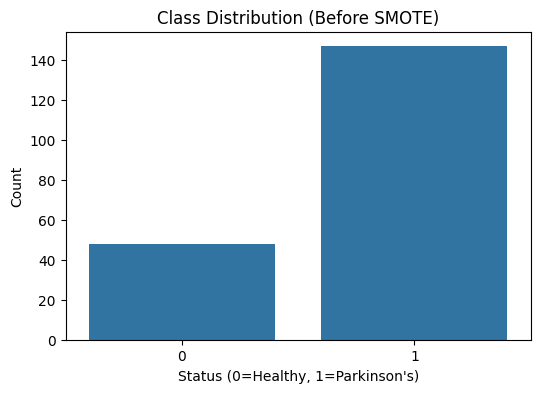

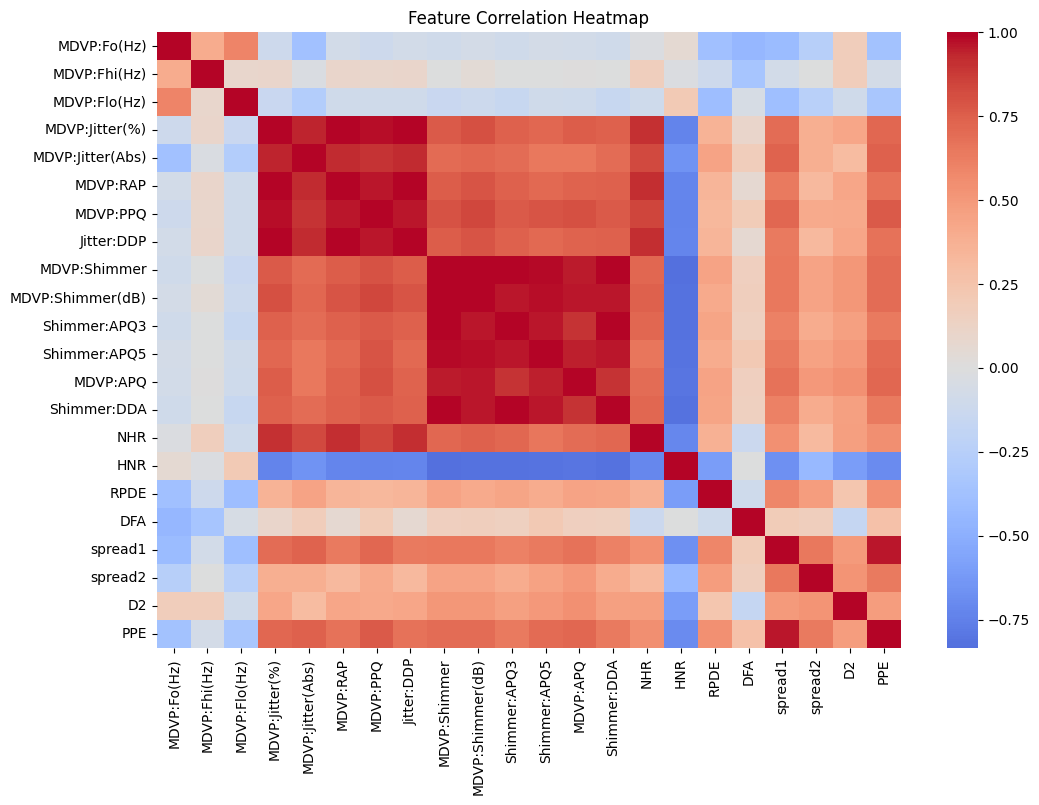

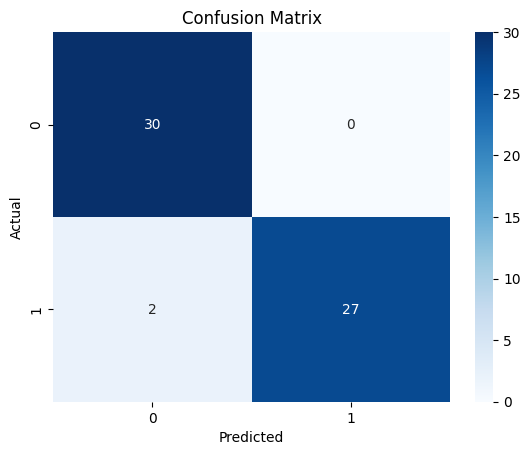

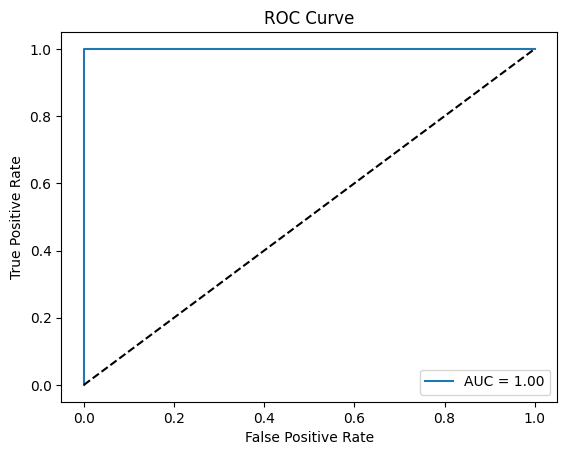

In [ ]:

# PARKINSON'S DISEASE PREDICTION
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class ParkinsonPredictor:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.feature_names = None
        self.X_test = None
        self.y_test = None

    def load_data(self, filepath):
        data = pd.read_csv(filepath)
        X = data.drop(['name', 'status'], axis=1)
        y = data['status']
        self.feature_names = X.columns.tolist()
        return X, y

    def preprocess(self, X, y):
        X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X_res)
        return X_scaled, y_res

    def train(self, X, y):
        X_train, self.X_test, y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
        self.model = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(self.X_test)
        print("Model Evaluation:")
        print(classification_report(self.y_test, y_pred))
        return self

    def save(self, model_path, scaler_path):
        with open(model_path, 'wb') as f:
            pickle.dump(self.model, f)
        with open(scaler_path, 'wb') as f:
            pickle.dump(self.scaler, f)
        print(f"Model saved to {model_path}")
        print(f"Scaler saved to {scaler_path}")
        return self

    def predict(self, input_features):
        try:
            input_array = np.array(input_features).reshape(1, -1)
            if hasattr(self.scaler, 'feature_names_in_'):
                input_df = pd.DataFrame(input_array, columns=self.scaler.feature_names_in_)
                scaled_input = self.scaler.transform(input_df)
            else:
                scaled_input = self.scaler.transform(input_array)
            pred = self.model.predict(scaled_input)[0]
            proba = self.model.predict_proba(scaled_input)[0][1]
            return {
                'prediction': 'Parkinson\'s Detected' if pred == 1 else 'Healthy',
                'probability': f"{proba:.1%}",
                'confidence': self._get_confidence_level(proba)
            }
        except Exception as e:
            print(f"Prediction error: {str(e)}")
            return None

    def _get_confidence_level(self, probability):
        if probability > 0.9: return 'Very High'
        elif probability > 0.7: return 'High'
        elif probability > 0.5: return 'Moderate'
        return 'Low'

# Example Usage
if __name__ == "__main__":
    predictor = ParkinsonPredictor()
    X, y = predictor.load_data('parkinsons.csv')
    X_scaled, y_res = predictor.preprocess(X, y)
    predictor.train(X_scaled, y_res)
    predictor.save('parkinsons_model.pkl', 'scaler.pkl')

    sample = [
        119.992, 157.302, 74.997, 0.00784, 0.00007, 0.0037, 0.00554,
        0.01109, 0.04374, 0.426, 0.02182, 0.0313, 0.02971, 0.06545,
        0.02211, 21.033, 0.414783, 0.815285, -4.813031, 0.266482,
        2.301442, 0.284654
    ]
    result = predictor.predict(sample)
    print("\n=== PREDICTION RESULT ===")
    for k, v in result.items():
        print(f"{k.title():<12}: {v}")

    # Plotting with Save
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title("Class Distribution (Before SMOTE)")
    plt.xlabel("Status (0=Healthy, 1=Parkinson's)")
    plt.ylabel("Count")
    plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(12, 8))
    corr = X.corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
    plt.title("Feature Correlation Heatmap")
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    y_pred = predictor.model.predict(predictor.X_test)
    cm = confusion_matrix(predictor.y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    y_prob = predictor.model.predict_proba(predictor.X_test)[:, 1]
    fpr, tpr, _ = roc_curve(predictor.y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Optional: Force download all plots
    # from google.colab import files
    # files.download('class_distribution.png')
    # files.download('correlation_heatmap.png')
    # files.download('confusion_matrix.png')
    # files.download('roc_curve.png')
